In [7]:
# Install PySpark
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, round, when

# Initialize Spark session
spark = SparkSession.builder \
    .appName("EnergyUsageAnalysis") \
    .getOrCreate()

# 1. Load the data files (upload these files to Colab first)
device_usage_df = spark.read.csv("device_usage_breakdown (1).csv", header=True)
monthly_totals_df = spark.read.csv("monthly_totals (2).csv", header=True)

# Convert string columns to appropriate types
device_usage_df = device_usage_df.withColumn("Air Conditioner", col("Air Conditioner").cast("double")) \
                                .withColumn("Heater", col("Heater").cast("double")) \
                                .withColumn("Server Rack Fan", col("Server Rack Fan").cast("double"))

monthly_totals_df = monthly_totals_df.withColumn("usage_kwh", col("usage_kwh").cast("double"))

# 2. Show the loaded data
print("Device Usage Breakdown:")
device_usage_df.show()

print("\nMonthly Totals:")
monthly_totals_df.show()

# 3. Calculate device contribution percentages
usage_with_percentages = device_usage_df.join(monthly_totals_df, "month") \
    .withColumn("AC_pct", round(col("Air Conditioner") / col("usage_kwh") * 100, 2)) \
    .withColumn("Heater_pct", round(col("Heater") / col("usage_kwh") * 100, 2)) \
    .withColumn("Fan_pct", round(col("Server Rack Fan") / col("usage_kwh") * 100, 2))

print("\nUsage with Percentages:")
usage_with_percentages.show()

# 4. Calculate potential savings opportunities
savings_opportunities = usage_with_percentages.withColumn(
    "AC_savings_potential",
    when(col("AC_pct") > 40, "High")
     .when(col("AC_pct") > 30, "Medium")
     .otherwise("Low")
).withColumn(
    "Heater_savings_potential",
    when(col("Heater_pct") > 30, "High")
     .when(col("Heater_pct") > 20, "Medium")
     .otherwise("Low")
)

print("\nSavings Opportunities:")
savings_opportunities.show()

# 5. Save results (in Colab we'll use CSV, in Databricks you'd use Delta)
# Save as single CSV files for Colab
usage_with_percentages.toPandas().to_csv('device_usage_with_percentages.csv', index=False)
savings_opportunities.toPandas().to_csv('savings_opportunities.csv', index=False)

# For Databricks, you would use:
# usage_with_percentages.write.format("delta").mode("overwrite").save("/mnt/data/device_usage_with_percentages")
# savings_opportunities.write.format("delta").mode("overwrite").save("/mnt/data/savings_opportunities")

print("\nFiles saved successfully:")
print("- device_usage_with_percentages.csv")
print("- savings_opportunities.csv")

# 6. SQL Example (optional)
device_usage_df.createOrReplaceTempView("device_usage")
monthly_totals_df.createOrReplaceTempView("monthly_totals")

print("\nSQL Query Results:")
spark.sql("""
    SELECT d.month,
           d.`Air Conditioner` AS ac_kwh,
           m.usage_kwh,
           ROUND((d.`Air Conditioner` / m.usage_kwh) * 100, 2) AS ac_percentage
    FROM device_usage d
    JOIN monthly_totals m ON d.month = m.month
""").show()

# Clean up
spark.stop()

Device Usage Breakdown:
+-------+---------------+------+---------------+
|  month|Air Conditioner|Heater|Server Rack Fan|
+-------+---------------+------+---------------+
|2025-07|            7.5|   3.7|            5.8|
+-------+---------------+------+---------------+


Monthly Totals:
+-------+---------+
|  month|usage_kwh|
+-------+---------+
|2025-07|     17.0|
+-------+---------+


Usage with Percentages:
+-------+---------------+------+---------------+---------+------+----------+-------+
|  month|Air Conditioner|Heater|Server Rack Fan|usage_kwh|AC_pct|Heater_pct|Fan_pct|
+-------+---------------+------+---------------+---------+------+----------+-------+
|2025-07|            7.5|   3.7|            5.8|     17.0| 44.12|     21.76|  34.12|
+-------+---------------+------+---------------+---------+------+----------+-------+


Savings Opportunities:
+-------+---------------+------+---------------+---------+------+----------+-------+--------------------+------------------------+
|  mon

# 2. Show the loaded data

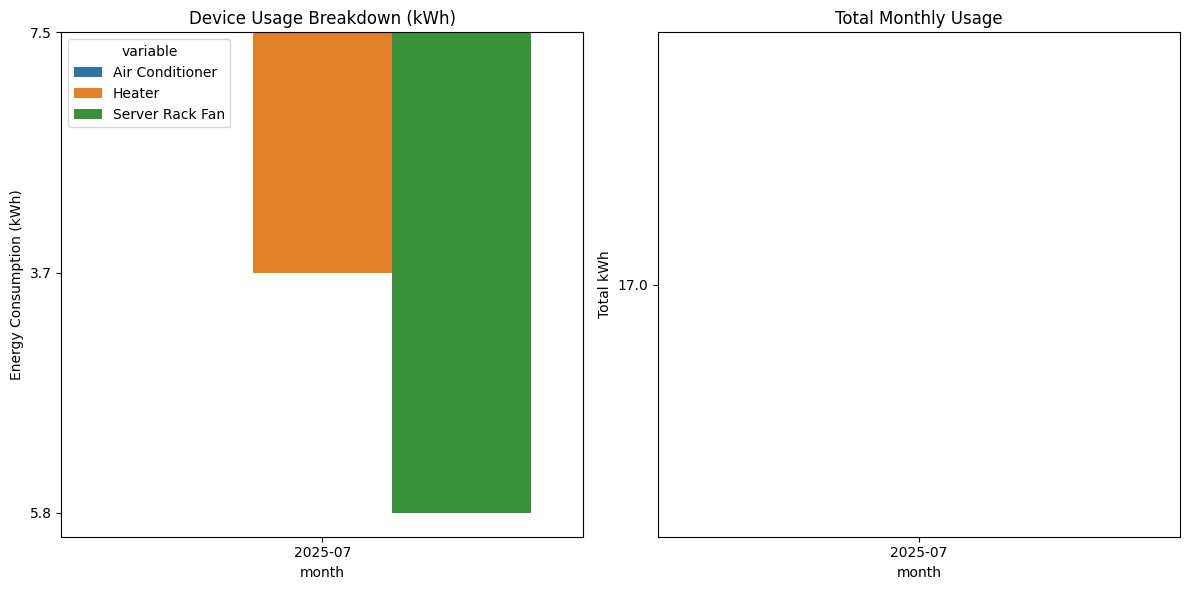

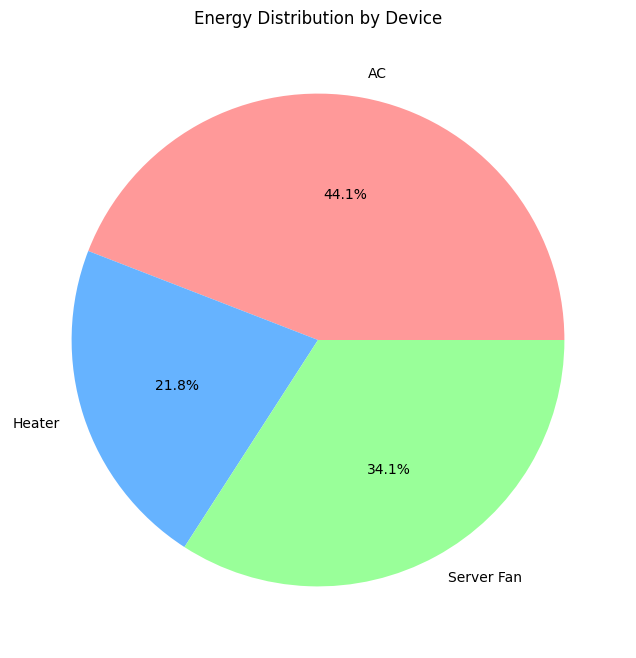

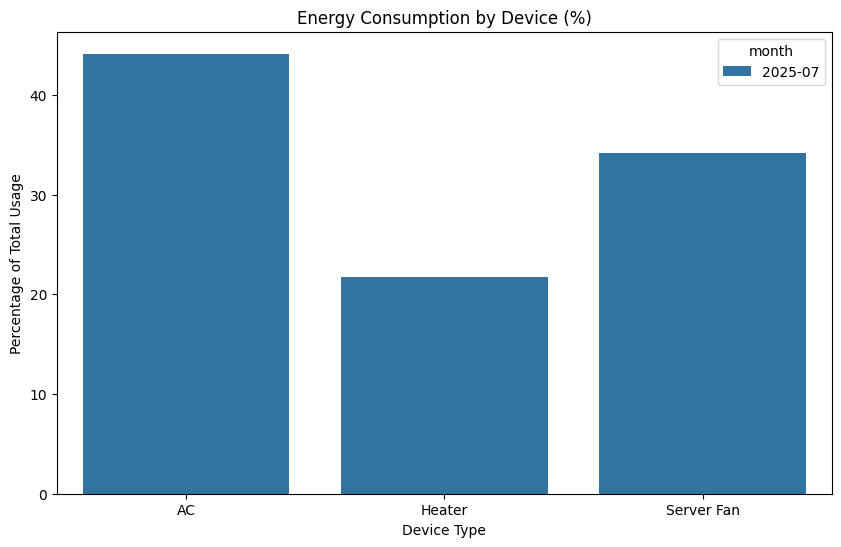

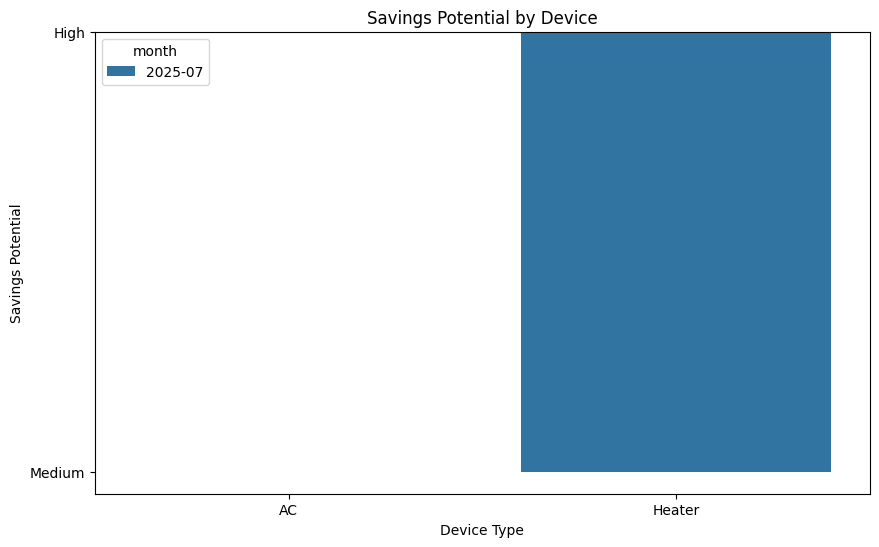


Visualizations saved and displayed:
- Device usage breakdown
- Energy distribution pie chart
- Savings potential analysis


In [4]:
# Install required packages
!pip install pyspark matplotlib seaborn

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, round, when
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder \
    .appName("EnergyUsageAnalysis") \
    .getOrCreate()

# 1. Load and prepare data
device_usage_df = spark.read.csv("device_usage_breakdown (1).csv", header=True)
monthly_totals_df = spark.read.csv("monthly_totals (2).csv", header=True)

# Convert to pandas for visualization
device_pd = device_usage_df.toPandas()
monthly_pd = monthly_totals_df.toPandas()

# 2. Basic Visualizations
plt.figure(figsize=(12, 6))

# Device Usage Breakdown
plt.subplot(1, 2, 1)
sns.barplot(data=device_pd.melt(id_vars='month'),
            x='month', y='value', hue='variable')
plt.title('Device Usage Breakdown (kWh)')
plt.ylabel('Energy Consumption (kWh)')

# Monthly Total Usage
plt.subplot(1, 2, 2)
sns.barplot(data=monthly_pd, x='month', y='usage_kwh')
plt.title('Total Monthly Usage')
plt.ylabel('Total kWh')

plt.tight_layout()
plt.show()

# 3. Advanced Analysis with Visualizations
analysis_df = device_usage_df.join(monthly_totals_df, "month") \
    .withColumn("AC_pct", round(col("Air Conditioner") / col("usage_kwh") * 100, 2)) \
    .withColumn("Heater_pct", round(col("Heater") / col("usage_kwh") * 100, 2)) \
    .withColumn("Fan_pct", round(col("Server Rack Fan") / col("usage_kwh") * 100, 2))

analysis_pd = analysis_df.toPandas()

# Pie Chart of Energy Distribution
plt.figure(figsize=(8, 8))
plt.pie(analysis_pd.iloc[0][['Air Conditioner', 'Heater', 'Server Rack Fan']],
        labels=['AC', 'Heater', 'Server Fan'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Energy Distribution by Device')
plt.show()

# 4. Savings Potential Visualization
savings_df = analysis_df.withColumn(
    "AC_savings",
    when(col("AC_pct") > 40, "High")
     .when(col("AC_pct") > 30, "Medium")
     .otherwise("Low")
).withColumn(
    "Heater_savings",
    when(col("Heater_pct") > 30, "High")
     .when(col("Heater_pct") > 20, "Medium")
     .otherwise("Low")
)

savings_pd = savings_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=savings_pd.melt(id_vars='month',
                                value_vars=['AC_pct', 'Heater_pct', 'Fan_pct']),
            x='variable', y='value', hue='month')
plt.title('Energy Consumption by Device (%)')
plt.xlabel('Device Type')
plt.ylabel('Percentage of Total Usage')
plt.xticks(ticks=[0, 1, 2], labels=['AC', 'Heater', 'Server Fan'])
plt.show()

# 5. Save visualizations
plt.figure(figsize=(10, 6))
sns.barplot(data=savings_pd.melt(id_vars='month',
                                value_vars=['AC_savings', 'Heater_savings']),
            x='variable', y='value', hue='month')
plt.title('Savings Potential by Device')
plt.xlabel('Device Type')
plt.ylabel('Savings Potential')
plt.xticks(ticks=[0, 1], labels=['AC', 'Heater'])
plt.savefig('savings_potential.png')
plt.show()

print("\nVisualizations saved and displayed:")
print("- Device usage breakdown")
print("- Energy distribution pie chart")
print("- Savings potential analysis")

# Clean up
spark.stop()

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, round, when

# Initialize Spark session
spark = SparkSession.builder \
    .appName("EnergyUsageAnalysis") \
    .getOrCreate()

# 1. Load the data files (upload these files to Colab first)
device_usage_df = spark.read.csv("device_usage_breakdown (1).csv", header=True)
monthly_totals_df = spark.read.csv("monthly_totals (2).csv", header=True)

# Convert string columns to appropriate types
device_usage_df = device_usage_df.withColumn("Air Conditioner", col("Air Conditioner").cast("double")) \
                                .withColumn("Heater", col("Heater").cast("double")) \
                                .withColumn("Server Rack Fan", col("Server Rack Fan").cast("double"))

monthly_totals_df = monthly_totals_df.withColumn("usage_kwh", col("usage_kwh").cast("double"))


# 3. Calculate device contribution percentages
usage_with_percentages = device_usage_df.join(monthly_totals_df, "month") \
    .withColumn("AC_pct", round(col("Air Conditioner") / col("usage_kwh") * 100, 2)) \
    .withColumn("Heater_pct", round(col("Heater") / col("usage_kwh") * 100, 2)) \
    .withColumn("Fan_pct", round(col("Server Rack Fan") / col("usage_kwh") * 100, 2))

print("\nUsage with Percentages:")
usage_with_percentages.show()


Usage with Percentages:
+-------+---------------+------+---------------+---------+------+----------+-------+
|  month|Air Conditioner|Heater|Server Rack Fan|usage_kwh|AC_pct|Heater_pct|Fan_pct|
+-------+---------------+------+---------------+---------+------+----------+-------+
|2025-07|            7.5|   3.7|            5.8|     17.0| 44.12|     21.76|  34.12|
+-------+---------------+------+---------------+---------+------+----------+-------+

